# Clean Data

### Imports

In [47]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import matplotlib.gridspec as gridspec
import seaborn as sns


## Clean NFL Combine Data

In [26]:
combine_file = r'data\nfl_combine_1987_2020.csv'

df_raw_combine = pd.read_csv(combine_file)

df_raw_combine.head()

# Keep raw data import for reference - build copy to modify
df_combine = df_raw_combine

# Drop dummy '0' column and Wonderlic scores data
combine_cols_to_drop = ['Unnamed: 0', 'Wonderlic']
df_combine.drop(columns=combine_cols_to_drop, inplace=True)

# Clean column headers
df_combine.columns = df_combine.columns.str.lower()
df_combine.rename(columns={'college':'school'}, inplace=True)

# Clean school names
df_combine['school'] = df_combine['school'].str.strip()

# Drop years prior to 2000 (no draft data)
print(df_combine.shape)
df_combine.drop(df_combine[df_combine['year']<2000].index, inplace=True)
print('Cleaned combine size: ', df_combine.shape)
df_combine.head()

(12808, 15)
Cleaned combine size:  (8465, 15)


,year,name,school,pos,height (in),weight (lbs),hand size (in),arm length (in),40 yard,bench press,vert leap (in),broad jump (in),shuttle,3cone,60yd shuttle
4343,2000,Darnell Alford,Boston College,OT,76.0,334,10.50,34.00,5.58,23.0,25.0,94.0,4.98,8.48,NaN
4344,2000,Kyle Allamon,Texas Tech,TE,74.5,253,9.88,31.00,5.01,NaN,29.0,104.0,4.49,7.29,12.47
4345,2000,Rashard Anderson,Jackson State (MS),CB,74.4,206,10.00,33.00,4.59,NaN,34.0,123.0,4.15,7.18,11.72
4346,2000,Corey Atkins,South Carolina,OLB,72.4,237,9.75,31.88,4.76,21.0,31.0,112.0,4.39,7.96,11.87
4347,2000,Reggie Austin,Wake Forest,CB,69.4,175,8.50,30.00,4.46,17.0,35.0,119.0,4.14,7.03,NaN


## Import position mapping data
The "combine" dataset maps players to very specific positions (ie, "Free Saftey" or "Outside Linebacker").

Map these granular positions to more standard positions. Also classify each position as "Offense" or "Defense", and indicate if the position is a "Skill" position or on the line of scrimmage.

In [27]:
df_positions = pd.read_csv('data/position_mapping.csv')
df_positions.head()

,pos,pos_group,offense_defense,line_or_skill
0,WR,WR,O,S
1,CB,CB,D,S
2,RB,RB,O,S
3,DE,DL,D,L
4,OT,OL,O,L


### Merge the draft and position mapping datasets

In [28]:
df_combine = df_combine.merge(df_positions,
                          how='left',
                          on='pos')

print(df_combine['pos_group'].value_counts())

df_combine.head()

OL      1409
DL      1331
WR      1095
LB      1027
CB       864
S        701
RB       700
TE       471
QB       470
K        200
FB       175
Snap      22
Name: pos_group, dtype: int64


,year,name,school,pos,height (in),weight (lbs),hand size (in),arm length (in),40 yard,bench press,vert leap (in),broad jump (in),shuttle,3cone,60yd shuttle,pos_group,offense_defense,line_or_skill
0,2000,Darnell Alford,Boston College,OT,76.0,334,10.50,34.00,5.58,23.0,25.0,94.0,4.98,8.48,NaN,OL,O,L
1,2000,Kyle Allamon,Texas Tech,TE,74.5,253,9.88,31.00,5.01,NaN,29.0,104.0,4.49,7.29,12.47,TE,O,S
2,2000,Rashard Anderson,Jackson State (MS),CB,74.4,206,10.00,33.00,4.59,NaN,34.0,123.0,4.15,7.18,11.72,CB,D,S
3,2000,Corey Atkins,South Carolina,OLB,72.4,237,9.75,31.88,4.76,21.0,31.0,112.0,4.39,7.96,11.87,LB,D,S
4,2000,Reggie Austin,Wake Forest,CB,69.4,175,8.50,30.00,4.46,17.0,35.0,119.0,4.14,7.03,NaN,CB,D,S


#### TODO:
Plot grid of histograms of position by data

https://www.machinelearningplus.com/plots/matplotlib-histogram-python-examples/

['OL', 'TE', 'CB', 'LB', 'S', 'DL', 'QB', 'RB', 'WR', 'FB']
Unique Positions:  10
Index(['year', 'name', 'school', 'pos', 'height (in)', 'weight (lbs)',
       'hand size (in)', 'arm length (in)', '40 yard', 'bench press',
       'vert leap (in)', 'broad jump (in)', 'shuttle', '3cone', '60yd shuttle',
       'pos_group', 'offense_defense', 'line_or_skill'],
      dtype='object')


AttributeError: 'Figure' object has no attribute 'plt'

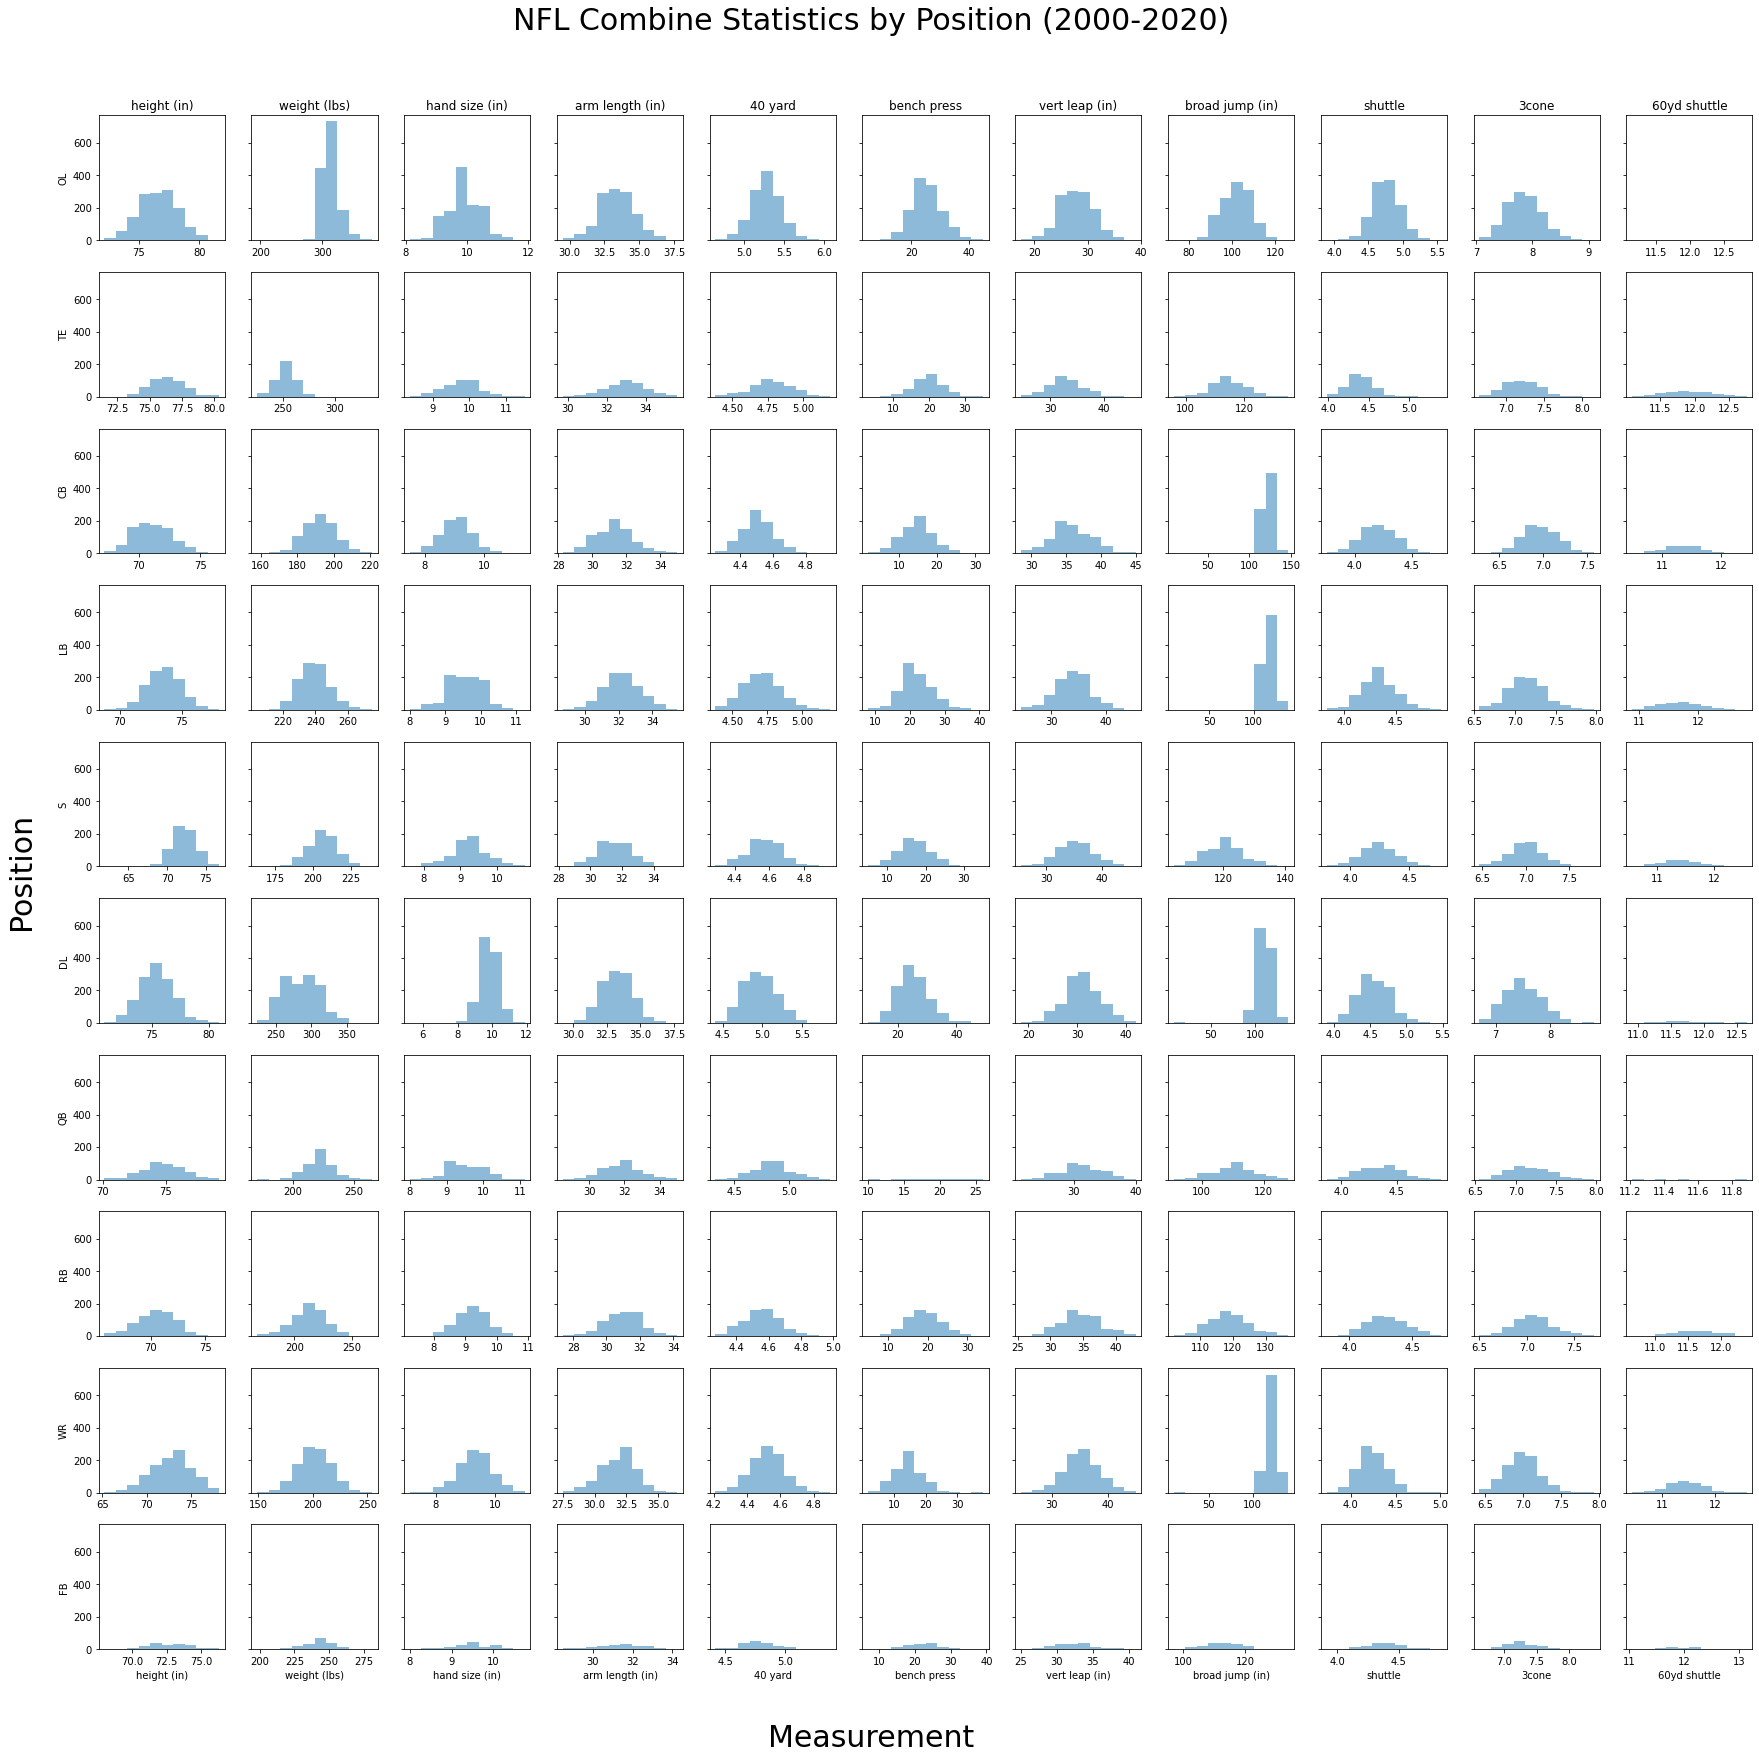

In [55]:
positions = df_combine['pos_group'].unique()

positions_to_drop = ['Snap', 'K']   # Long snappers and kickers/punters

positions = [pos for pos in positions if pos not in positions_to_drop]
print(positions)


print('Unique Positions: ', len(positions))
print(df_combine.columns)
stat_columns = ['height (in)', 'weight (lbs)',
       'hand size (in)', 'arm length (in)', '40 yard', 'bench press',
       'vert leap (in)', 'broad jump (in)', 'shuttle', '3cone', '60yd shuttle']
num_stats = len(stat_columns)
fig, axes = plt.subplots(len(positions), num_stats,
                         sharex=False,
                         sharey=True,
                         figsize=(25,25))


fig.suptitle('NFL Combine Statistics by Position (2000-2020)', fontsize=30)
fig.supxlabel('Measurement', fontsize=30)
fig.supylabel('Position', fontsize=30)

# fig.get_axes()[0].annotate('Long Suptitle', (0.5, 0.95),
#                             xycoords='figure fraction', ha='center',
#                             fontsize=24
#                             )
fig.tight_layout(rect=[0.03, 0.03, 1, .95])

# Loop over axes and data
for row, pos in enumerate(positions):
    x_positions = df_combine[df_combine['pos_group']==pos]

    for col, stat in enumerate(stat_columns):
        # Get axis
        ax = axes[row,col]
        x = x_positions[stat]
        ax.hist(x, alpha=.5, bins=10)
        # Set Y label once per row
        if col==0:
            ax.set_ylabel(pos)

        # Set X label once per column
        if row == 0:
            ax.set_title(stat)
        if row == len(positions) - 1:
            ax.set_xlabel(stat)

fig.plt()

Try to plot using seaborn's "Faceted Histograms"

In [ ]:
grid = sns.displot(
    data=df_combine,
    x='pos_group',

)

## Clean NFL Draft Data

In [ ]:
draft_file = r'data\espn_draft_history_2000_2021_cleaned.csv'
df_raw_draft = pd.read_csv(draft_file)

# Keep raw data import for reference - build copy to modify
df_draft = df_raw_draft

# Clean column headers
df_draft.columns = df_draft.columns.str.lower()

# Clean school names
df_draft['school'] = df_draft['school'].str.strip()


In [ ]:
# combine results by position
df_combine['pos'].value_counts()


### Are there duplicated names?

In [ ]:
df_combine['name'].value_counts(sort='descending').head(10)

### Answer: Yes

So we cannot simply join the 2 datasets on player 'name' columns. Need to also join on
college and year.


## Do college names match in both datasets?

In [ ]:
draft_school = pd.DataFrame(df_draft['school'].unique()).rename(columns={0:'school'})
draft_school['source'] = 'draft'
combine_school = pd.DataFrame(df_combine['school'].unique()).rename(columns={0:'school'})
combine_school['source'] = 'combine'
print(type(combine_school))
print(combine_school.head())

schools = draft_school.merge(combine_school, on='school', how='outer',
                             suffixes=['_draft', '_combine']).sort_values(by='school')

# List all cases with mismatches
na_mask = schools.isna().any(axis=1)
print(schools[na_mask])

### So we see that the 'combine' dataset frequently has the state appended to the school name;
Ex: "Abilene Christian (TX)". Remove these from school names, with the exception of "Miami (OH).

In [ ]:
df_combine['school'] = df_combine['school'].str.replace('Miami (OH)', 'Miami - OH')

print(df_combine['school'].head())
regex_replace_parens = r'\([^)]*[a-zA-Z][^)]*\)'
df_combine['school'] = df_combine['school'].str.replace(regex_replace_parens, '', regex=True)

print(df_combine['school'].head())

# pd.DataFrame(df_combine['school'].unique()).to_clipboard()
#
# schools2 = df_draft.merge(df_combine,
#                           on='school', how='outer',
#                           suffixes=['_draft', '_combine']).sort_values(by='school')
#
# na_mask = schools2.isna().any(axis=1)
# schools2[na_mask]
# pd.concat([df_combine['school'], df_draft['school']], join='outer')

#df_combine.merge(df_draft, how='left', on='school')

## Standardize player names between datasets
Player names in the "Draft" dataset include suffixes including "Jr., II, III, IV", but these are NOT included in the "combine" dataset.

Standardize player names between datasets by removing these values from the "Draft" dataset.

In [ ]:
regex_suffixes_to_remove = r'Jr\.$|III$|IIII$|IV$|, Jr.$'
df_draft['name'] = df_draft['name'].str.replace(regex_suffixes_to_remove, '', regex=True)

# df_draft['name'].to_clipboard()



Merge the Draft and NFL Combine datasets

In [ ]:
df_merged = df_combine.merge(df_draft, how='left',
                             on=['name', 'school', 'year'])

df_merged.head(10)

# df_merged.to_clipboard()

## Investigate merged data

In [ ]:
df_merged.info()
